### This notebook will be used to fulfill the IBM Certification Coursera Capstone

In [1]:
conda install -c conda-forge wordcloud

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    wordcloud-1.8.0            |   py37h8f50634_0         190 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.3 MB

The following NEW packages will be INSTALLED:

  wordcloud          conda-forge/linux-64::wordcloud-1.8.0-py37h8f50634_0

The following packages will be UPDATED:

  openssl                                 1.1.1g-h516909a_1 --> 1.1.1h-h516909a_0



openssl-1.1.1h       | 2.1 MB    | ##################################### | 100% 
wordcloud-1.8.0      | 190 KB    | ##################################### | 100% 
Preparing transaction: done
Verif

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import log_loss

# Introduction

Road transportation, while convenient, gives rise to road accidents with varying severity. According to The Organisation for Economic Co-operation and Development (OECD), in 2017, the United States registered 1.923 million road accidents involving casualties. These accidents may happen for several reasons either pertaining to the driver, the vehicle(s), and/or weather conditions. While the most notable repercussions of road accidents are fatal and non-fatal injuries to the people involved, as well as the wrecking of the vehicle(s), traffic congestions also occur as a result. The extent of these three consequences depends on the severity of the accident. Therefore, predicting the severity of an accident may facilitate estimation of the human and material harm or losses, help emergency responders provide care effectively and efficiently, thus also reducing traffic congestions.

# Methodology

### Data Description

The raw data set employed was downloaded from Kaggle, a data science website hosting open source data sets. The data set contains 3.5 million records of countrywide road accidents in the United States, and 47 attributes (excluding the identification column and the road severity label column). The observations cover about 49 states and span a period from February 2016 to June 2020. The data was collected from sources such as traffic cameras, traffic sensors, law enforcement agencies, and the US Department of Transportation.

In our methodology, we will first perform an exploratory data analysis (e.g. feature engineering, correlation, patterns, etc.) to better understand the data set at hand. Then we will delve into cleaning and preprocessing our data set to prepare it for the modeling phase. This step includes dealing with missing data points, balancing our labeled data, and splitting our data into training and testing chunks. Next, since we are dealing with a labeled categorical target (i.e. supervised learning), we will experiment with various classification algorithms and evaluate their performance using metrics such as Jaccard Index, F1-Score, and Log Loss.

In [2]:
# Import the data and display the first 5 observations
accident_data = pd.read_csv("../input/us-accidents/US_Accidents_June20.csv")
accident_data.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
print('Number of Rows :', accident_data.shape[0])
print('Number of Columns :', accident_data.shape[1])
print('Features :', accident_data.columns.tolist())

Number of Rows : 3513617
Number of Columns : 49
Features : ['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


In [4]:
# Since most machine learning algorithms do not admit categorical variables
# Investigate which variables are categorical
cats = accident_data.select_dtypes(exclude=['int','float']).columns
print(cats)
print("\nThe number of categorical variables is: ", len(cats))

Index(['ID', 'Source', 'Start_Time', 'End_Time', 'Description', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Wind_Direction',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')

The number of categorical variables is:  34


## Exploratory Data Analysis

In [6]:
# Investigate whether some rows are duplicates
accident_data.duplicated().sum()

0

Text(0, 0.5, 'Number of Accidents')

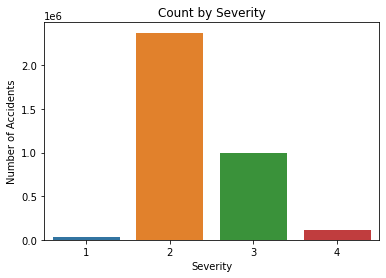

In [7]:
# Target Variable: Severity (may require target )
ax = sns.countplot('Severity', data=accident_data)
ax.set_title('Count by Severity')
ax.set_ylabel('Number of Accidents')

The target variable seems to be unevenly distributed with the most observed accident Severity being 2. Using this target 
variable as it is can cause our model to be biased and to display a "naive behavior".

Text(0, 0.5, 'Number of Accidents')

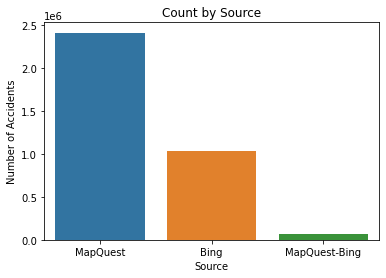

In [8]:
# Source 
ax1 = sns.countplot('Source', data=accident_data, order = accident_data['Source'].value_counts().index)
ax1.set_title('Count by Source')
ax1.set_ylabel('Number of Accidents')


In [9]:
# TMC
accident_data[['TMC', 'Severity']].groupby(['Severity'], as_index = False).mean()

,Severity,TMC
0,1,203.301498
1,2,205.367876
2,3,213.033623
3,4,228.614056


It seems that a TMC is positively correlated with Severity such that a high TMC corresponds to a higher accident severity.

### Attributes Related to Time

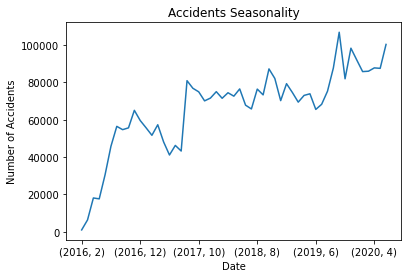

In [3]:
# Accident Trend
accident_data.Start_Time= pd.to_datetime(accident_data.Start_Time, format='%Y-%m-%d %H:%M:%S')
accident_data.End_Time = pd.to_datetime(accident_data.End_Time, format='%Y-%m-%d %H:%M:%S')

year = pd.DatetimeIndex(accident_data['Start_Time']).year
month = pd.DatetimeIndex(accident_data['Start_Time']).month

accident_data.groupby(by = [year, month]).count()['Severity'].plot()
                               
plt.title('Accidents Seasonality')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.show()

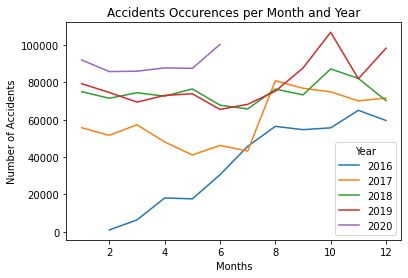

In [11]:
pv = pd.pivot_table(accident_data, index=month, columns= year,
                    values='Severity', aggfunc='count')

pv.plot()
plt.xlabel('Months')
plt.ylabel('Number of Accidents')
plt.title('Accidents Occurences per Month and Year')
plt.legend(title = 'Year')

We notice some seasonality in the occurence of accidents such that there are more accidents in October and November.
We also notice an increasing trend for each year excluding 2018.

The 20 largest accident durations correspond to 81.8% of the data


Text(0, 0.5, 'Percentage of Accidents (%)')

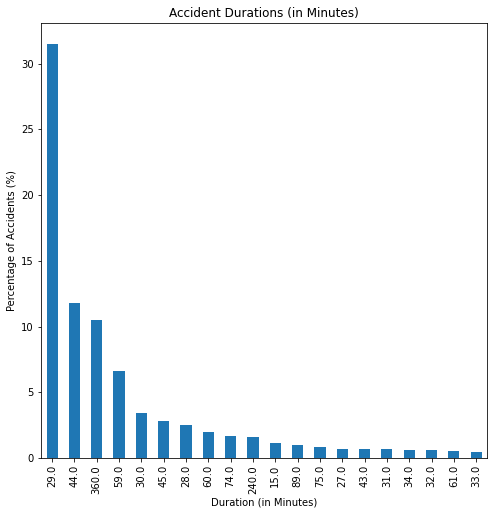

In [4]:
# Duration of the accidents
diff = accident_data['End_Time'] - accident_data['Start_Time']

top20 = diff.astype('timedelta64[m]').value_counts().nlargest(20)
print('The 20 largest accident durations correspond to {:.1f}% of the data'.format(top20.sum()*100/len(diff)))

(top20/len(accident_data)*100).plot.bar(figsize=(8,8))
plt.title('Accident Durations (in Minutes)')
plt.xlabel('Duration (in Minutes)')
plt.ylabel('Percentage of Accidents (%)')

About 45% of the accidents were resolved under 1 hour while about 10% of the accidents were resolved in 6 hours.

In [5]:
# Add column Duration to our dataframe
accident_data['Duration(min)'] = diff.astype('timedelta64[m]')

In [14]:
# Investigate the duration to clear traffic for each severity score
accident_data[['Severity', 'Duration(min)']].groupby(['Severity']).mean()

,Duration(min)
Severity,
1,40.280352
2,103.487570
3,77.266006
4,708.506330


As expected, accidents of severity 4 take longer to deal with. However, in our datasets, on average, accidents of severity
2 take longer to take care of than accidents of severity 3.

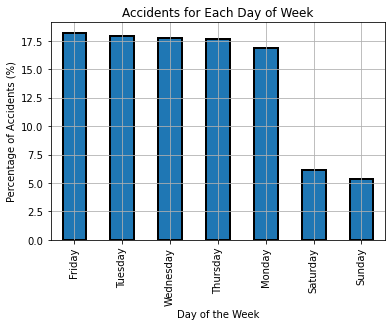

In [6]:
# Investigate week seasonality
accident_data['DayOfWeek'] = accident_data['Start_Time'].dt.day_name()

count = accident_data['DayOfWeek'].value_counts(ascending=False)*100/len(accident_data)
count.plot.bar(width=0.5, edgecolor='k', align='center',linewidth=2)
plt.xlabel('Day of the Week')
plt.ylabel('Percentage of Accidents (%)')
plt.title('Accidents for Each Day of Week')
plt.grid()

About 90% of accidents happen Monday through Friday

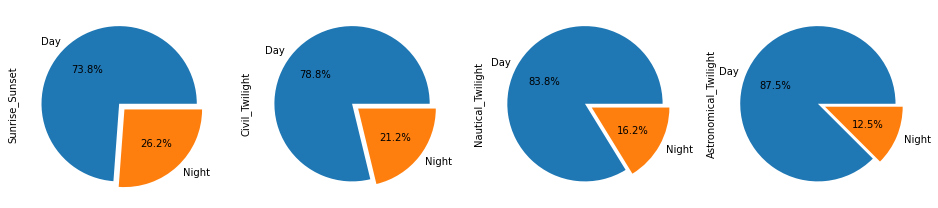

In [20]:
# Time of occurence (Day vs. Night)
f2,ax2 =plt.subplots(1, 4 ,figsize=(16,6))
accident_data['Sunrise_Sunset'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax2[0])
accident_data['Civil_Twilight'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax2[1])
accident_data['Nautical_Twilight'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax2[2])
accident_data['Astronomical_Twilight'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax2[3])

In [7]:
# Since there are 4 measures (i.e. Sunrise_Sunset, Civil_Twilight, Nautical_Twilight, Astronomical_Twilight), we take a vote.
accident_data[['Sunrise_Sunset']] = (accident_data['Sunrise_Sunset'] == 'Day')
accident_data[['Civil_Twilight']] = (accident_data['Civil_Twilight'] == 'Day')
accident_data[['Nautical_Twilight']] = (accident_data['Nautical_Twilight'] == 'Day')
accident_data[['Astronomical_Twilight']] = (accident_data['Astronomical_Twilight'] == 'Day')

accident_data['Day_Night'] = accident_data[['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
                                           'Astronomical_Twilight']].sum(axis = 1)
    
accident_data['Day_Night'] = accident_data['Day_Night']/4
accident_data[['Day_Night']].round(decimals = 0)

,Day_Night
0,0.0
1,0.0
2,0.0
3,1.0
4,1.0
...,...
3513612,1.0
3513613,1.0
3513614,1.0
3513615,1.0


In [8]:
# Drop columns used to generate Day_Night
accident_data.drop(['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis = 1, inplace = True)

### Location attributes

These 10 states account for 65.5% of the total number of observed accidents


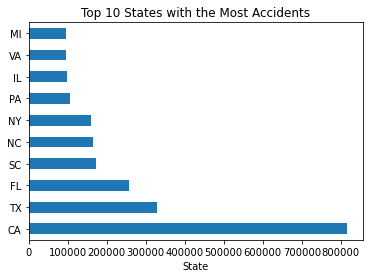

In [24]:
# Show top 10 states with the most accidents
top10 = accident_data.State.value_counts().sort_values(ascending = False)[:10]
top10.plot(kind='barh')
plt.title('Top 10 States with the Most Accidents')
plt.xlabel('State')

print('These 10 states account for {:.1f}% of the total number of observed accidents'.format(top10.sum()/len(accident_data)*100))

California has the most accidents (about 23% of the total number of accidents in the data set), followed by Texas, Florida, South Carolina, North Carolina, New York, Pennsylvania, Illinois, Virginia, and Michigan.

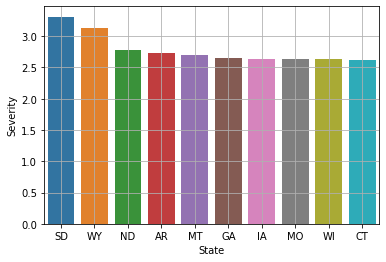

In [25]:
# States with the highest accident severity score
top_Severity= accident_data.groupby('State').agg({'Severity': 'mean'}).sort_values('Severity', ascending = False) .reset_index()
sns.barplot(y="Severity", x="State", data=top_Severity.head(10))
plt.grid()

South Dakota, Wyoming, North Dakota, Arkansas, Montana, Georgia, Iowa, Missouri, Wisconsin, and Connecticut have the highest accident severity score. 

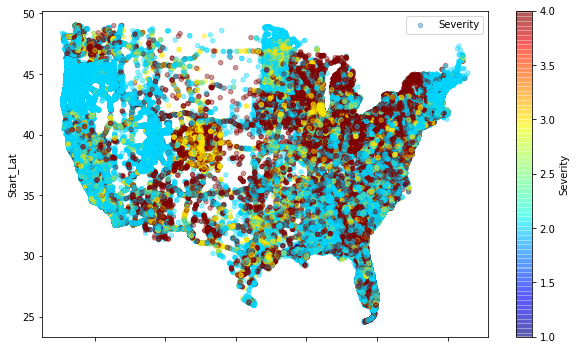

In [26]:
# Visualize all locations of the accidents
sub=accident_data[accident_data.Severity < 5]
pt=sub.plot(kind='scatter', x='Start_Lng',y='Start_Lat',label='Severity',c='Severity',cmap=plt.get_cmap('jet'),
                 colorbar=True, alpha=0.4, figsize=(10, 6))
pt.legend()
plt.ioff()

The map is on par with the results previously obtained about the states with the more severe accident occurences.

Text(0, 0.5, '')

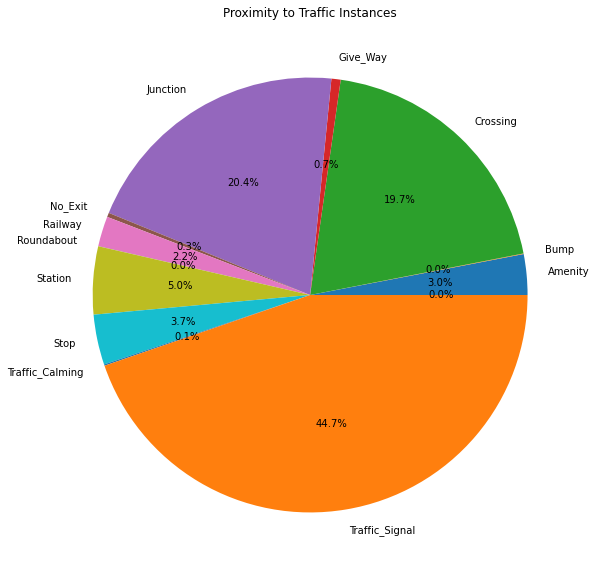

In [29]:
# Proximity to traffic instances
cols =accident_data[['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
                    'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']].sum(axis = 0)

cols.plot.pie(autopct='%1.1f%%', figsize = (10, 10))
plt.title('Proximity to Traffic Instances');
plt.ylabel('')

Traffic signals, junctions and crossings seem to be the traffic instances next to which most accidents happen (about 84.8%).

In [9]:
# Drop all traffic instance columns except Traffic_Signal, Junction, and Crossing
accident_data.drop(['Amenity', 'Bump', 'Give_Way', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
                    'Traffic_Calming', 'Turning_Loop'], axis = 1, inplace = True)

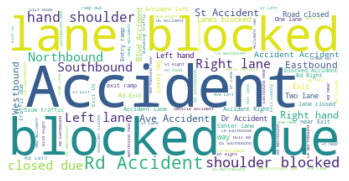

In [31]:
# Generate word cloud to find most words used in the accidents descriptions
stopwords = set(STOPWORDS)
w = accident_data['Description'].str.split("(").str[0].value_counts().keys()
words = WordCloud(background_color = 'white', max_words = 1000, stopwords = stopwords)
words.generate(' '.join(w))
plt.imshow(words, interpolation = 'bilinear')
plt.axis('off')
plt.show()

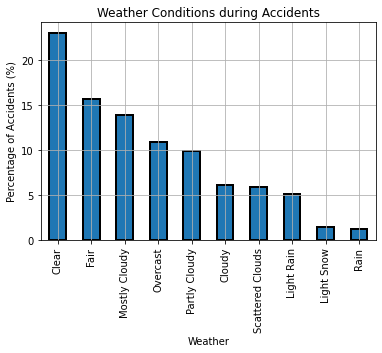

In [32]:
# Investigate weather conditions
count1 = accident_data['Weather_Condition'].value_counts(ascending=False)[:10]*100/len(accident_data)
count1.plot.bar(width=0.5, edgecolor='k', align='center',linewidth=2)
plt.xlabel('Weather')
plt.ylabel('Percentage of Accidents (%)')
plt.title('Weather Conditions during Accidents')
plt.grid()

39% of accidents happened in clear and fair weather conditions. And about 8% of accidents happened in rain and snow.

## Data Pre-Processing

In [10]:
# Feature Engineering: Delete irrelevant columns 
# Columns such as Distance(mi) and Duration are not available before an accident occurs, therefore they can't be used for prediction
accident_data.drop (['End_Lat', 'End_Lng', 'Number','ID', 'Source', 'TMC', 'Start_Time', 'Distance(mi)', 'Description', 'Side', 'County', 'Zipcode',
                     'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Duration(min)', 'Wind_Direction', 
                    'Weather_Condition', 'End_Time', 'City', 'State', 'Street'], axis = 1, inplace = True)

In [11]:
# Calculate the % of missing values in each row
accident_data.isna().mean().sort_values(ascending = False).round(4) * 100

Precipitation(in)    57.66
Wind_Chill(F)        53.17
Wind_Speed(mph)      12.94
Visibility(mi)        2.16
Humidity(%)           1.98
Temperature(F)        1.87
Pressure(in)          1.59
Day_Night             0.00
DayOfWeek             0.00
Traffic_Signal        0.00
Junction              0.00
Crossing              0.00
Start_Lng             0.00
Start_Lat             0.00
Severity              0.00
dtype: float64

In [12]:
# Delete variables with more than 50% missing data
accident_data.drop(['Precipitation(in)', 'Wind_Chill(F)'], axis = 1, inplace = True)

In [13]:
accident_data['Wind_Speed(mph)'].replace(np.nan, accident_data['Wind_Speed(mph)'].mean(), inplace = True)
accident_data['Humidity(%)'].replace(np.nan, accident_data['Humidity(%)'].mean(), inplace = True)
accident_data['Temperature(F)'].replace(np.nan, accident_data['Temperature(F)'].mean(), inplace = True)
accident_data['Pressure(in)'].replace(np.nan, accident_data['Pressure(in)'].mean(), inplace = True)
accident_data['Visibility(mi)'].replace(np.nan, accident_data['Visibility(mi)'].mean(), inplace = True)

In [14]:
# Check for missing data again
accident_data.isna().mean().sort_values(ascending = False).round(4) * 100

Day_Night          0.0
DayOfWeek          0.0
Traffic_Signal     0.0
Junction           0.0
Crossing           0.0
Wind_Speed(mph)    0.0
Visibility(mi)     0.0
Pressure(in)       0.0
Humidity(%)        0.0
Temperature(F)     0.0
Start_Lng          0.0
Start_Lat          0.0
Severity           0.0
dtype: float64

In [15]:
# Correct type of attributes
print(accident_data.dtypes)
accident_data['Day_Night'].astype(bool)

# Deal with categorical variable DayOfWeek
accident_data['DayOfWeek'] = accident_data['DayOfWeek'].astype('category')
accident_data['DayOfWeekcat'] = accident_data['DayOfWeek'].cat.codes
accident_data.drop(['DayOfWeek'], axis = 1, inplace = True)

Severity             int64
Start_Lat          float64
Start_Lng          float64
Temperature(F)     float64
Humidity(%)        float64
Pressure(in)       float64
Visibility(mi)     float64
Wind_Speed(mph)    float64
Crossing              bool
Junction              bool
Traffic_Signal        bool
DayOfWeek           object
Day_Night          float64
dtype: object


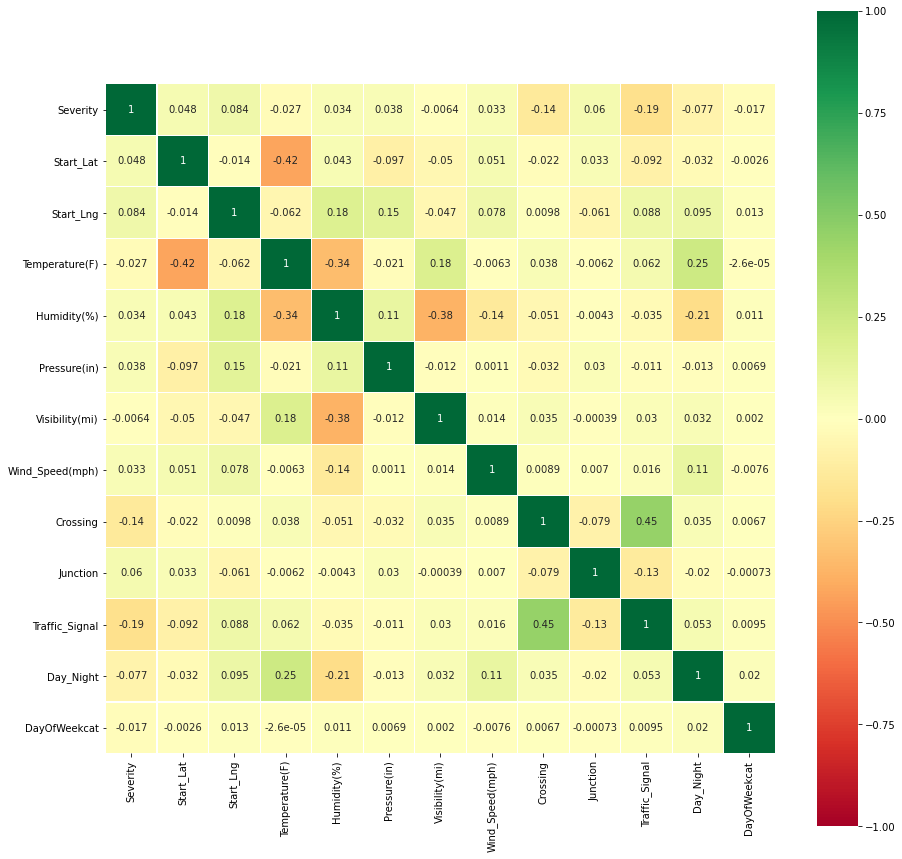

In [80]:
# Check correlation
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(accident_data.corr(), annot=True, vmin=-1, vmax=1, center=0, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10}, square=True, ax = ax)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

In [16]:
Y = accident_data['Severity']
X = accident_data.drop(['Severity'], axis = 1)

## Modelling

In this section we apply three classification machine learning algorithms: Decision Trees, K-Nearest Neighbors, and Logistic Regression.
The metrics used for comparison are: the Jaccard Index, F1-Score, and the Log Loss.

In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=1)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2810893, 12) (2810893,)
Test set: (702724, 12) (702724,)


In [18]:
# Standardize the data
X_train_pre = preprocessing.StandardScaler().fit_transform (X_train)
X_test_pre = preprocessing.StandardScaler().fit_transform(X_test)

### Decision Trees

In [19]:
# Modelling
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
tree.fit(X_train_pre, y_train)
predTree = tree.predict(X_test_pre)

In [25]:
# Evaluation Metrics
# Jaccard Index
print(jaccard_score(y_test, predTree, average = 'micro'))
# F1-Score
print(f1_score(y_test, predTree, average = 'weighted'))

0.5101350952048885
0.5448218352370706


### Logistic Regression

In [26]:
# Modelling
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_pre, y_train)
yhat2 = LR.predict(X_test_pre)
yhat_prob = LR.predict_proba(X_test_pre)

In [28]:
# Evaluation Metrics 
# Jaccard Index
print(jaccard_score(y_test, yhat2, average = 'micro'))
# F1-Score
print(f1_score(y_test, yhat2, average = 'weighted'))
# Log Loss
print(log_loss(y_test, yhat_prob))

0.5103022435615008
0.5489437559424283
0.7293869062592364


From the results above, we conclude that the best classifier for our dataset is Logistic Regression